In [ ]:
pip install --upgrade pip

In [ ]:
pip install yfinance

In [ ]:
pip install matplotlib

In [ ]:
pip install seaborn

In [ ]:
pip install pandas_datareader

In [ ]:
pip install --upgrade yfinance

In [ ]:
pip install scikit-learn

In [ ]:
pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Initialize Spark Session
# spark = (
#     SparkSession.builder
#     .appName("StockDataAnalysis")
#     .master("spark://172.17.6.255:7077")
#     .getOrCreate()
# )

spark = (
    SparkSession.builder
    .appName("StockDataAnalysis")
    .master("local[*]")  # Use local mode with all available cores
    .getOrCreate()
)

# Set up plotting styles
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TIF']
company_name = ["APPLE", "AMAZON", "GOOGLE", "MICROSOFT", "TIFFANY"]

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

# Dictionary to store Spark DataFrames for each stock
spark_dfs = {}
pandas_dfs = {}

# Load data from CSV files for each stock using Spark
for stock, name in zip(tech_list, company_name):
    # Adjust file path as needed, using the stock ticker
    file_path = f"hdfs://localhost:9000/{stock}.csv"
    try:
        # Read the CSV file into a Spark DataFrame
        data = spark.read.csv(file_path, header=True, inferSchema=True)
        # Add the company name as a new column
        data = data.withColumn("company_name", F.lit(name))
        # Store the Spark DataFrame in the dictionary
        spark_dfs[stock] = data
        # Convert to Pandas DataFrame for analysis
        pandas_dfs[stock] = data.toPandas()
    except Exception as e:
        print(f"Error loading data for {stock}: {e}")

# Example: Access and display the last few rows for AAPL using Spark
if 'AAPL' in spark_dfs:
    print("Last 10 rows for Apple (AAPL):")
    spark_dfs['AAPL'].orderBy("Date", ascending=False).show(10)

# Example: Analyze AAPL with Pandas
if 'AAPL' in pandas_dfs:
    print("\nPandas DataFrame for AAPL:")
    print(pandas_dfs['AAPL'].tail())

Last 10 rows for Apple (AAPL):
+----------+------+--------+-------+------+-------+----+------------+
|      date|  open|    high|    low| close| volume|Name|company_name|
+----------+------+--------+-------+------+-------+----+------------+
|2018-02-07|112.09|114.5799|  109.9|109.93|2163545| AAP|       APPLE|
|2018-02-06|108.28|  113.11|106.745| 112.2|1240784| AAP|       APPLE|
|2018-02-05|113.05|  114.97| 109.81|109.86|1281592| AAP|       APPLE|
|2018-02-02|115.92|  117.18|113.125|113.93|1092333| AAP|       APPLE|
|2018-02-01|116.24|  118.83| 115.83|117.29| 760629| AAP|       APPLE|
|2018-01-31|119.86|  120.47|115.825|116.99|1235733| AAP|       APPLE|
|2018-01-30|121.57|   122.7|117.575|119.27|1889671| AAP|       APPLE|
|2018-01-29|123.52|  123.63| 122.72|122.89|1403699| AAP|       APPLE|
|2018-01-26|123.34|   123.9| 121.66|123.64|1488390| AAP|       APPLE|
|2018-01-25|121.12|  121.34| 119.63|120.92|1250816| AAP|       APPLE|
+----------+------+--------+-------+------+-------+----+---

In [2]:
print("\nSummary statistics for Apple (AAPL):")
print(pandas_dfs['AAPL'].describe())


Summary statistics for Apple (AAPL):
              open         high          low        close        volume
count  1259.000000  1259.000000  1259.000000  1259.000000  1.259000e+03
mean    132.439631   133.818297   131.036025   132.433463  1.078043e+06
std      31.269628    31.545809    30.968405    31.274463  1.019365e+06
min      76.040000    76.660000    75.623000    76.180000  1.307120e+05
25%     104.070000   105.724950   102.260000   104.440000  6.182010e+05
50%     141.150000   143.000000   139.405000   141.300000  8.491350e+05
75%     156.980000   158.270000   155.320000   156.730000  1.219762e+06
max     201.240000   201.240000   198.160000   200.380000  1.974952e+07


In [3]:
# General info
print("\nGeneral information for Apple (AAPL):")
pandas_dfs['AAPL'].info()


General information for Apple (AAPL):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1259 non-null   object 
 1   open          1259 non-null   float64
 2   high          1259 non-null   float64
 3   low           1259 non-null   float64
 4   close         1259 non-null   float64
 5   volume        1259 non-null   int32  
 6   Name          1259 non-null   object 
 7   company_name  1259 non-null   object 
dtypes: float64(4), int32(1), object(3)
memory usage: 73.9+ KB


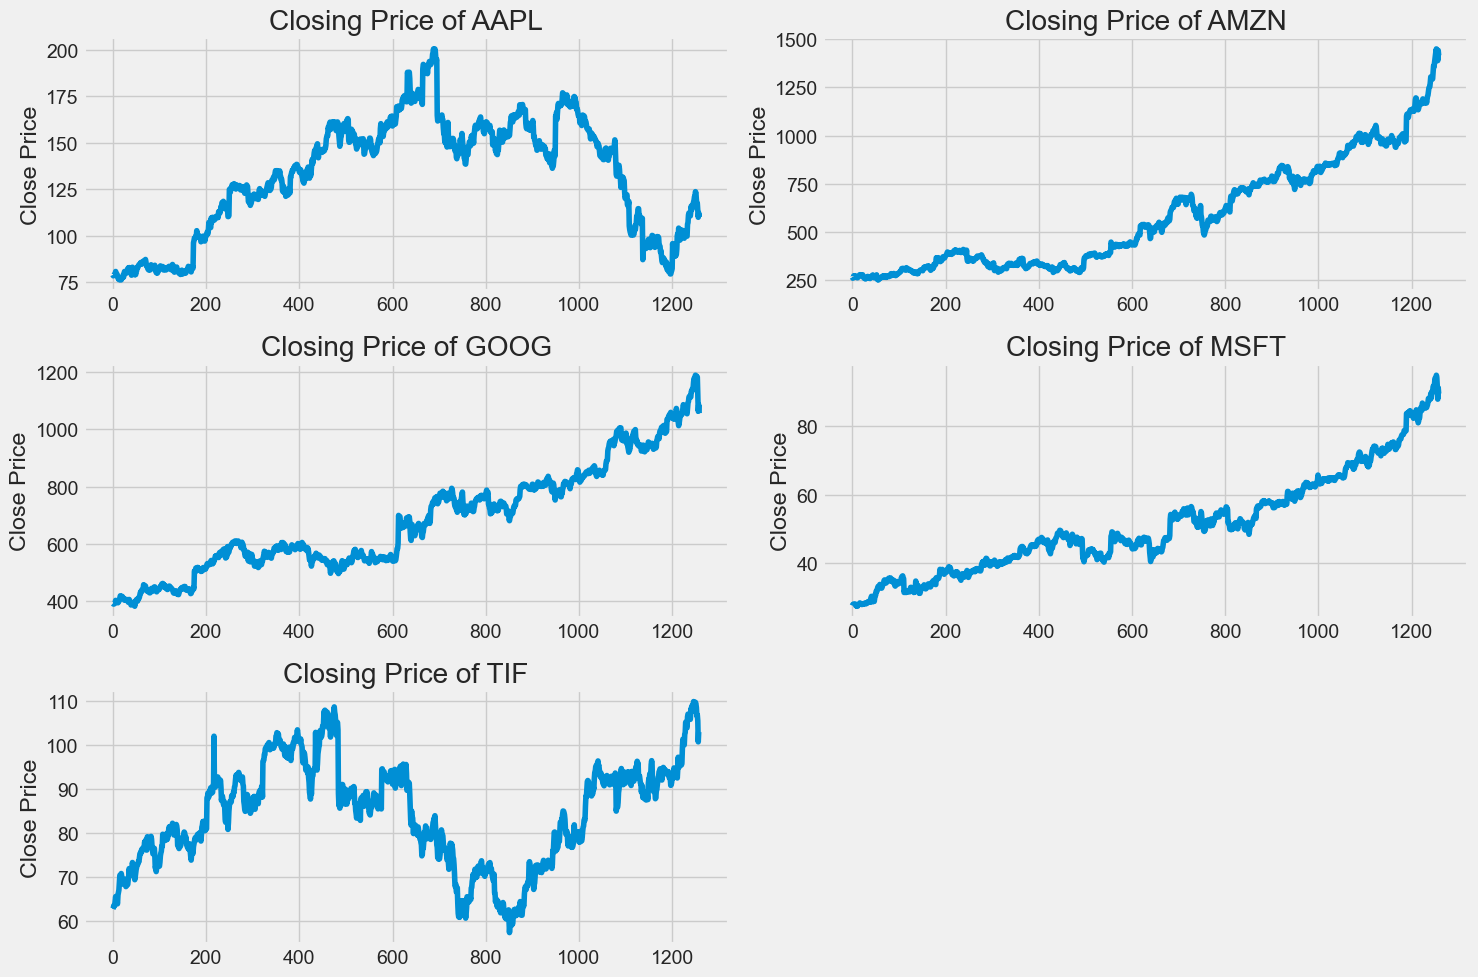

In [4]:
# Let's see a historical view of the closing price
import math

plt.figure(figsize=(15, 10))

# Calculate the number of rows and columns needed for subplots
num_plots = len(pandas_dfs)
cols = 2  # Fix the number of columns
rows = math.ceil(num_plots / cols)  # Dynamically calculate rows

# Iterate through the Pandas DataFrames stored in pandas_dfs
for i, (ticker, company_df) in enumerate(pandas_dfs.items(), 1):
    plt.subplot(rows, cols, i)  # Adjust subplot to dynamically fit the grid
    company_df['close'].plot()  # Use 'close' instead of 'Adj Close'
    plt.ylabel('Close Price')
    plt.xlabel(None)
    plt.title(f"Closing Price of {ticker}")

plt.tight_layout()
plt.show()

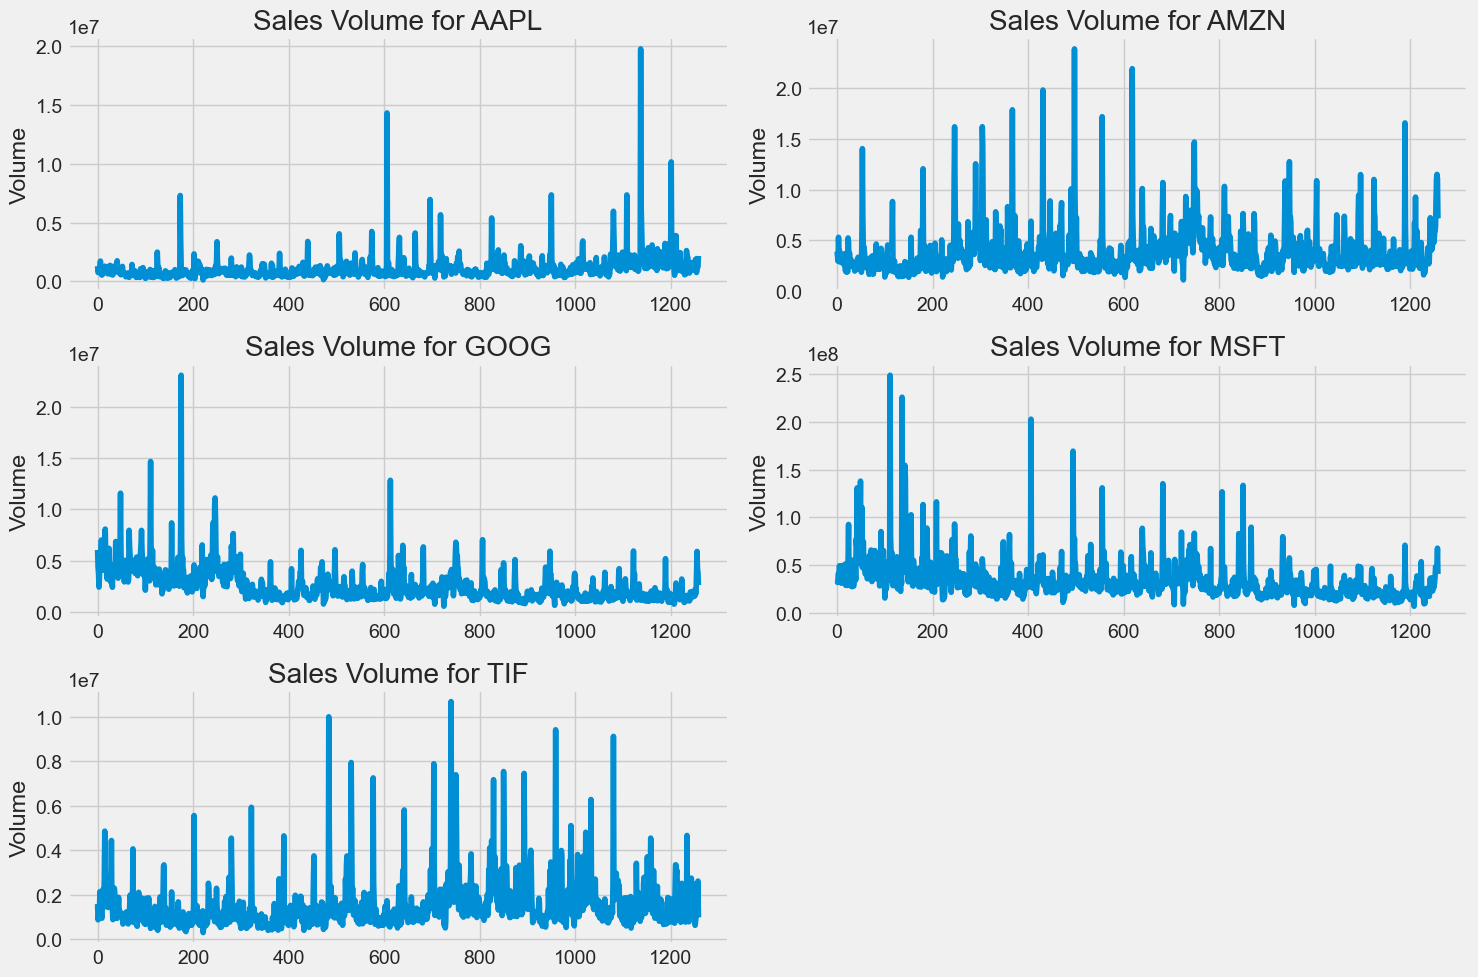

In [6]:
# Now let's plot the total volume of stock being traded each day
import math

plt.figure(figsize=(15, 10))

# Calculate the number of rows and columns needed for subplots
num_plots = len(pandas_dfs)
cols = 2  # Fixed number of columns
rows = math.ceil(num_plots / cols)  # Dynamically calculate rows

# Iterate through the Pandas DataFrames stored in pandas_dfs
for i, (ticker, company_df) in enumerate(pandas_dfs.items(), 1):
    plt.subplot(rows, cols, i)  # Adjust subplot to dynamically fit the grid
    if 'volume' in company_df.columns:  # Ensure the column exists
        company_df['volume'].plot()
        plt.ylabel('Volume')
        plt.xlabel(None)
        plt.title(f"Sales Volume for {ticker}")
    else:
        print(f"Column 'volume' not found in {ticker}")

plt.tight_layout()
plt.show()

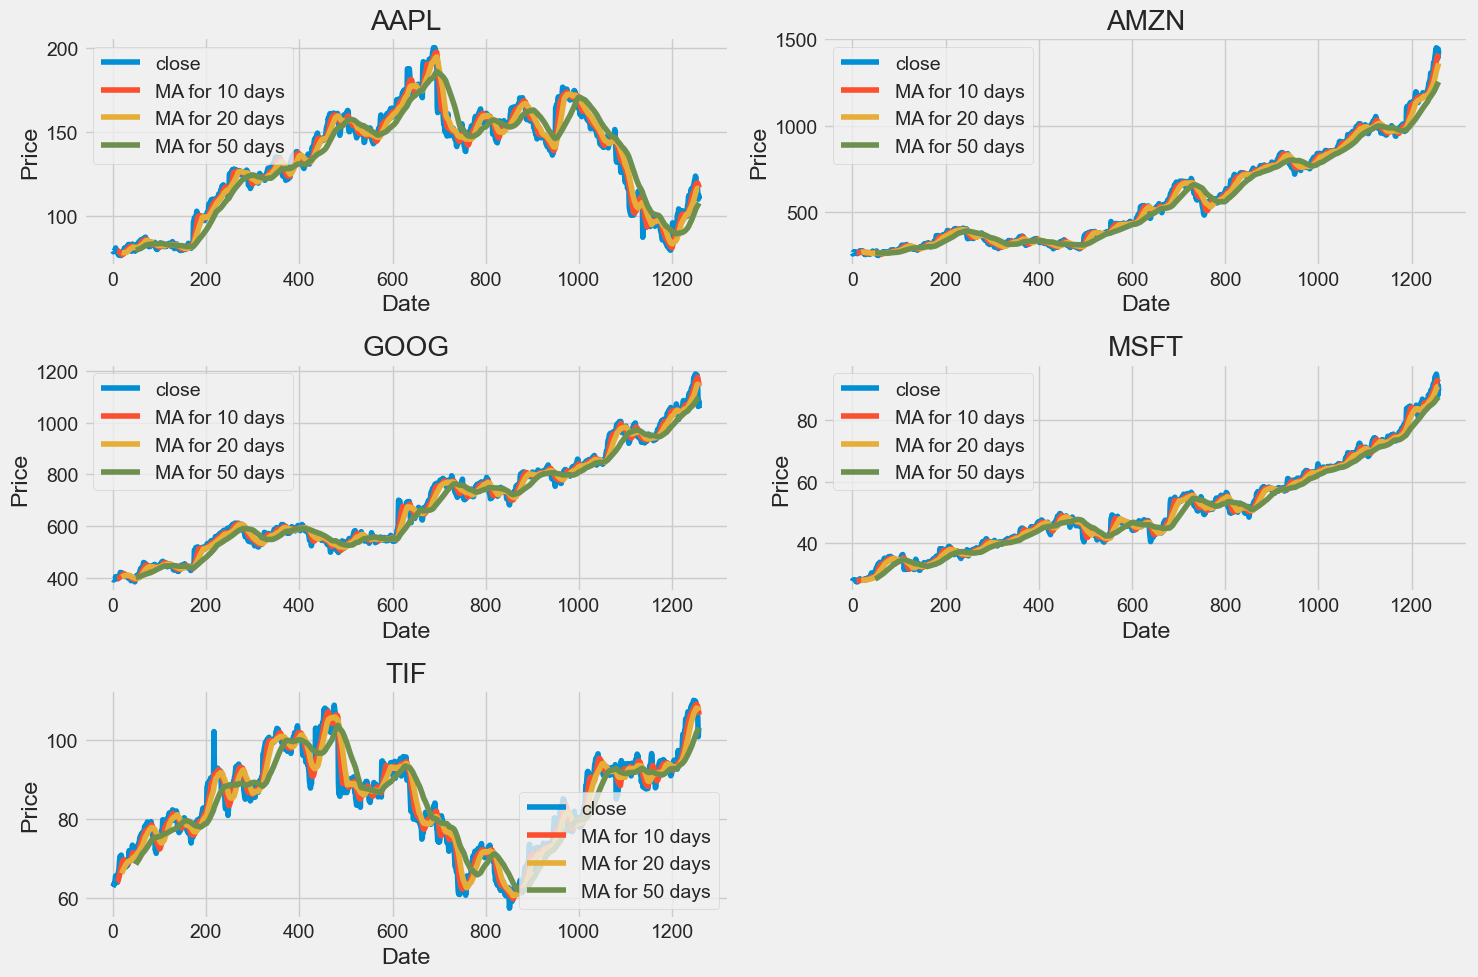

In [8]:
ma_day = [10, 20, 50]

# Calculate moving averages for each company
for ticker, company_df in pandas_dfs.items():
    for ma in ma_day:
        column_name = f"MA for {ma} days"
        company_df[column_name] = company_df['close'].rolling(ma).mean()  # Use 'close'

# Set up dynamic subplot grid
import math
num_plots = len(pandas_dfs)
cols = 2
rows = math.ceil(num_plots / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

# Flatten axes for easier indexing in case of a non-rectangular grid
axes = axes.flatten()

# Plot data for each company
for i, (ticker, company_df) in enumerate(pandas_dfs.items()):
    company_df[['close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[i])
    axes[i].set_title(ticker)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price')

# Remove any unused subplots
for j in range(len(pandas_dfs), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

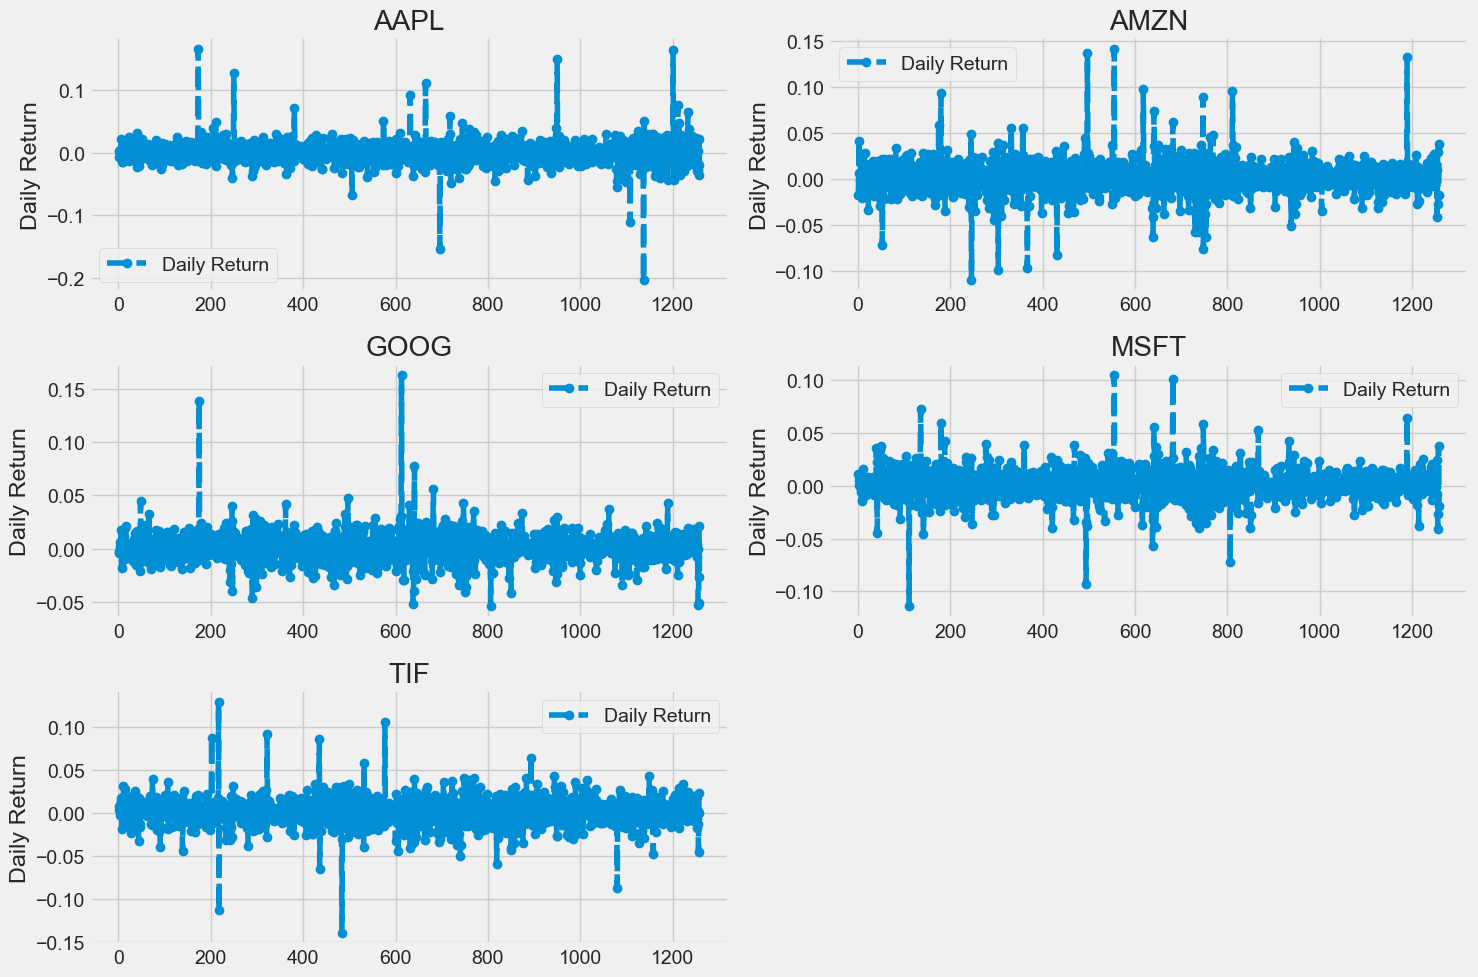

In [11]:
# Calculate daily returns for each company
for ticker, company_df in pandas_dfs.items():
    company_df['Daily Return'] = company_df['close'].pct_change()  # Use 'close' instead of 'Adj Close'

import math

# Dynamically calculate rows and columns
num_plots = len(pandas_dfs)
cols = 2  # Fixed number of columns
rows = math.ceil(num_plots / cols)  # Calculate rows dynamically

# Set up the grid for plotting
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))

# Flatten axes to handle non-rectangular grids
axes = axes.flatten()

# Plot daily returns for each company
for i, (ticker, company_df) in enumerate(pandas_dfs.items()):
    company_df['Daily Return'].plot(ax=axes[i], legend=True, linestyle='--', marker='o')
    axes[i].set_title(ticker)
    axes[i].set_ylabel('Daily Return')

# Remove any unused subplots
for j in range(len(pandas_dfs), len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

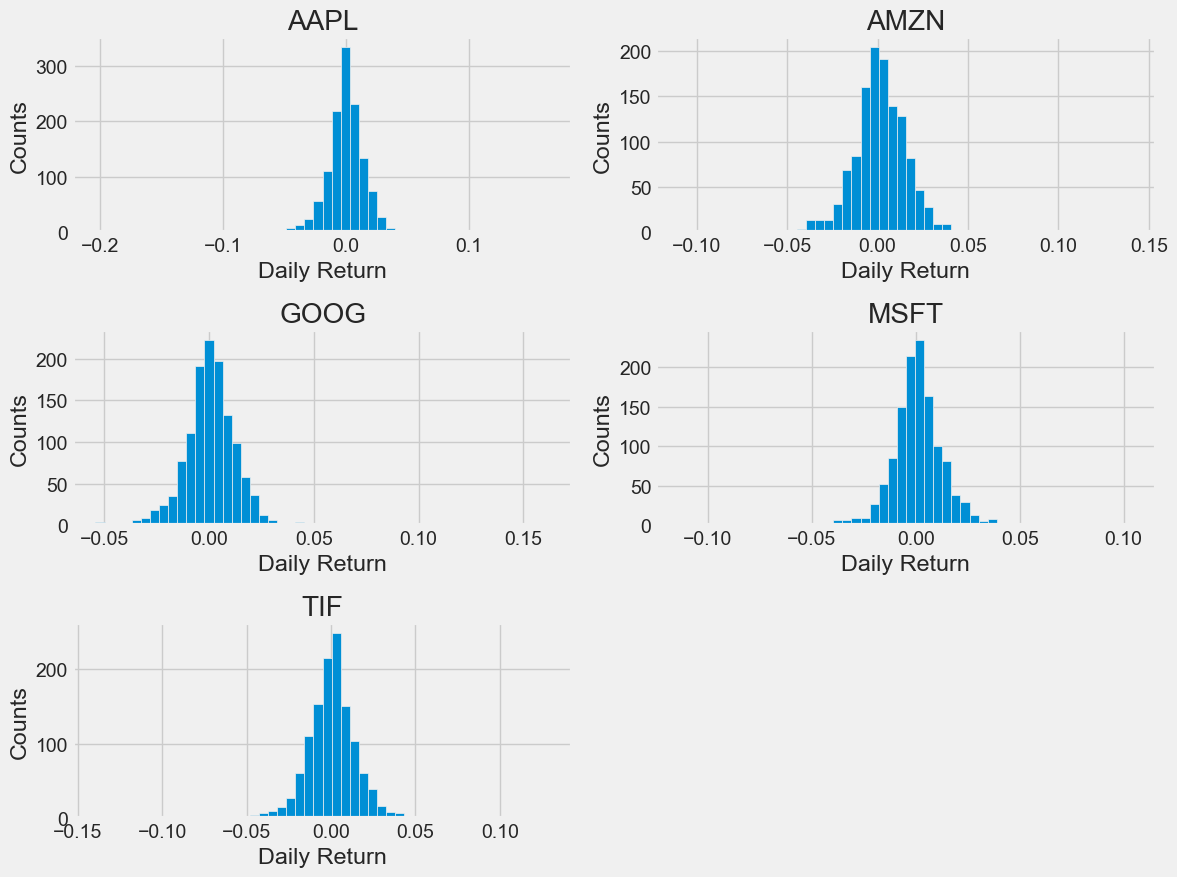

In [13]:
plt.figure(figsize=(12, 9))

# Add a 'Daily Return' column to each DataFrame
for ticker, company_df in pandas_dfs.items():
    if 'close' in company_df.columns:  # Check if the 'close' column exists
        company_df['Daily Return'] = company_df['close'].pct_change()
    else:
        print(f"'close' column not found for {ticker}")

# Calculate the number of rows and columns for subplots dynamically
import math
num_plots = len(pandas_dfs)
cols = 2  # Fixed number of columns
rows = math.ceil(num_plots / cols)  # Dynamically calculate rows

# Plot histograms for daily returns
for i, (ticker, company_df) in enumerate(pandas_dfs.items(), 1):
    plt.subplot(rows, cols, i)
    if 'Daily Return' in company_df.columns:  # Ensure 'Daily Return' exists
        company_df['Daily Return'].hist(bins=50)
        plt.xlabel('Daily Return')
        plt.ylabel('Counts')
        plt.title(f'{ticker}')
    else:
        print(f"'Daily Return' not calculated for {ticker}")

plt.tight_layout()
plt.show()

In [15]:
# Create a DataFrame with closing prices for all stocks
closing_df = pd.DataFrame({ticker: df['close'] for ticker, df in pandas_dfs.items()})

# Create a new DataFrame for returns
tech_rets = closing_df.pct_change()

# Display the first few rows
tech_rets.head()

,AAPL,AMZN,GOOG,MSFT,TIF
0,NaN,NaN,NaN,NaN,NaN
1,-0.006464,-0.018095,-0.003756,0.011252,0.003339
2,0.002679,0.005793,-0.002198,0.000718,0.007924
3,0.004707,0.041631,0.002767,0.005380,-0.002358
4,-0.001646,-0.000854,0.006336,0.000357,0.003940


In [17]:
for ticker, df in pandas_dfs.items():
    if 'close' not in df.columns:
        print(f"'close' column not found in {ticker}")

'GOOG' and 'MSFT' columns found in tech_rets with non-missing entries:
- GOOG: 1258 non-missing entries
- MSFT: 1258 non-missing entries


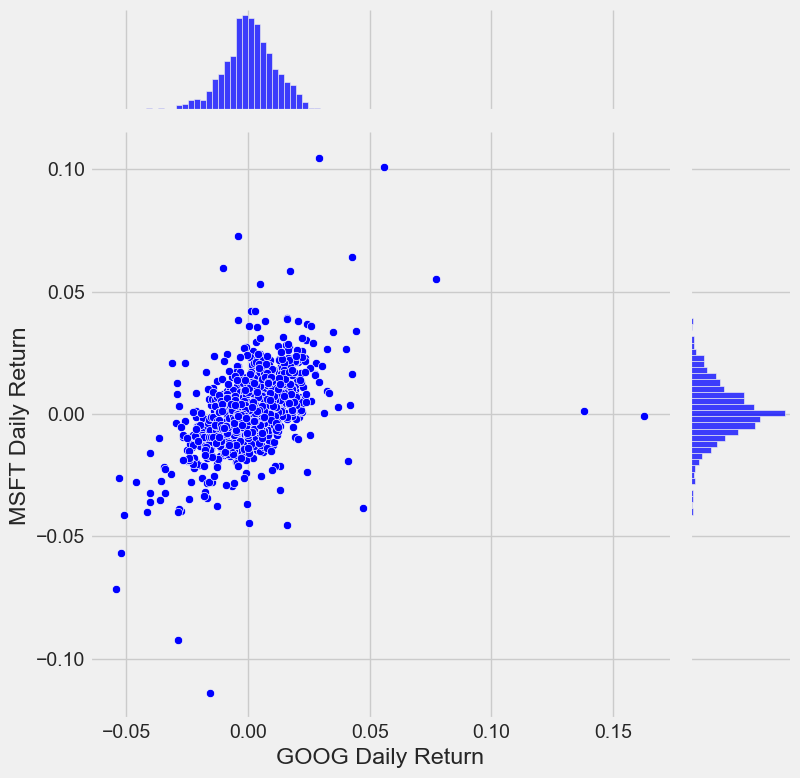

In [19]:
# Ensure 'GOOG' and 'MSFT' exist in the DataFrame
if 'GOOG' in tech_rets.columns and 'MSFT' in tech_rets.columns:
    print(f"'GOOG' and 'MSFT' columns found in tech_rets with non-missing entries:")
    print(f"- GOOG: {tech_rets['GOOG'].dropna().shape[0]} non-missing entries")
    print(f"- MSFT: {tech_rets['MSFT'].dropna().shape[0]} non-missing entries")
    
    # Drop rows with NaN in either 'GOOG' or 'MSFT'
    filtered_data = tech_rets[['GOOG', 'MSFT']].dropna()
    
    # Create the jointplot
    sns.jointplot(
        x='GOOG', y='MSFT', data=filtered_data, 
        kind='scatter', color='blue', height=8
    ).set_axis_labels("GOOG Daily Return", "MSFT Daily Return")
else:
    print("Error: 'GOOG' or 'MSFT' column not found in tech_rets DataFrame")

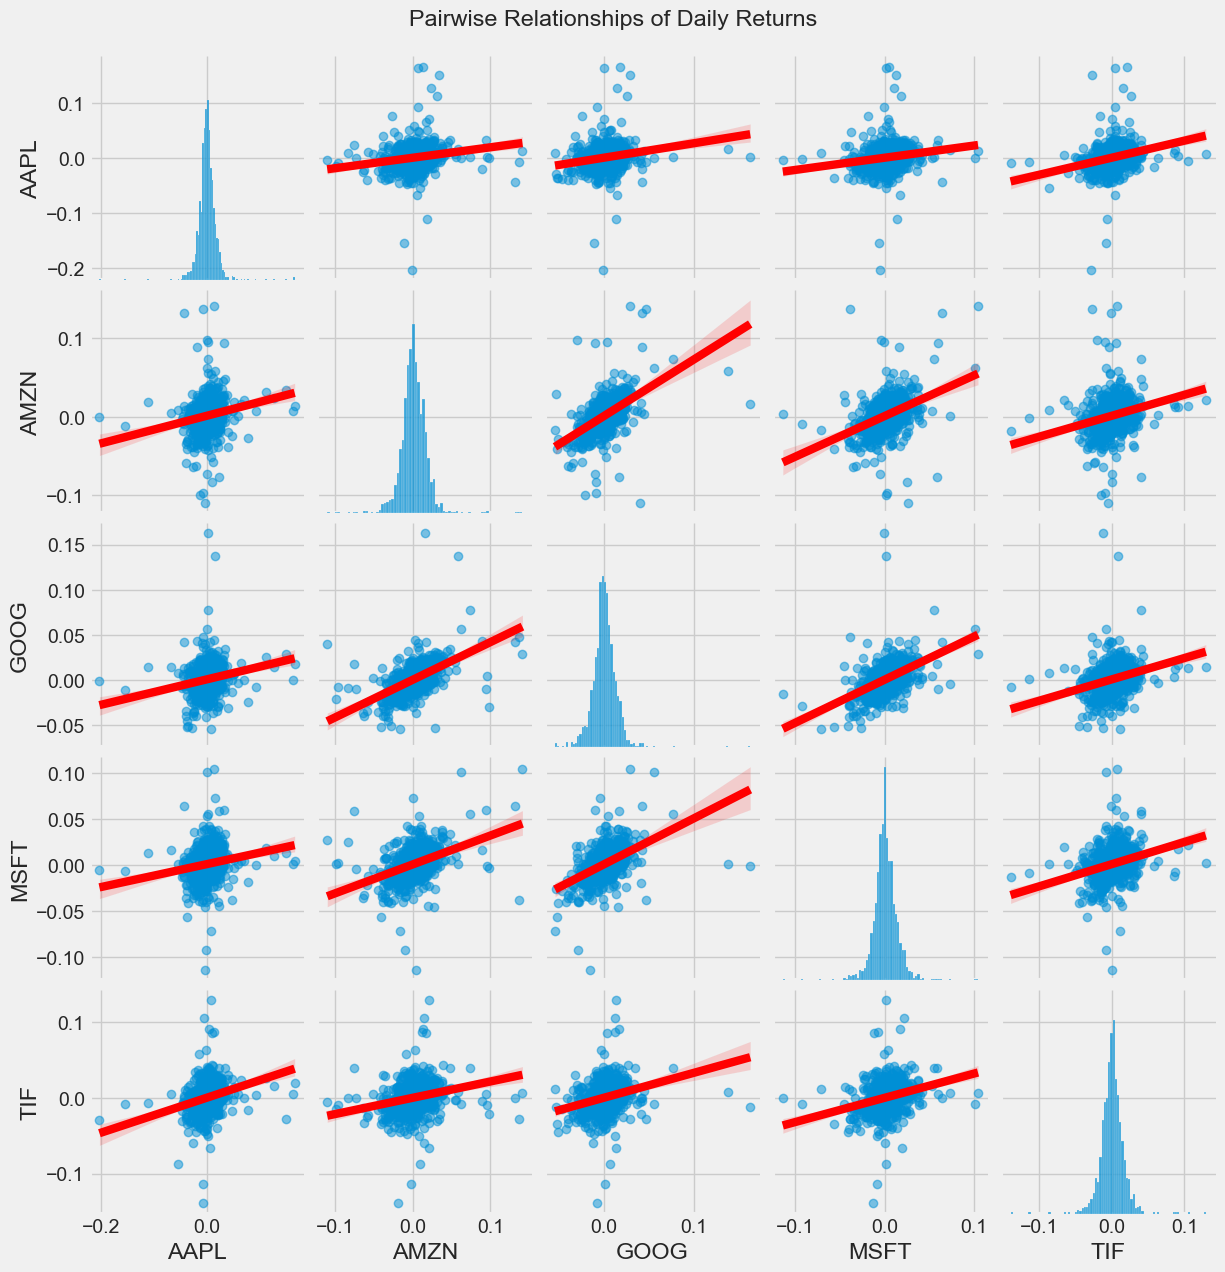

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with NaN to avoid issues in the pairplot
cleaned_tech_rets = tech_rets.dropna()

# Create the pairplot
sns.pairplot(cleaned_tech_rets, kind='reg', plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.5}})

# Add a title for better context
plt.suptitle("Pairwise Relationships of Daily Returns", y=1.02)
plt.show()

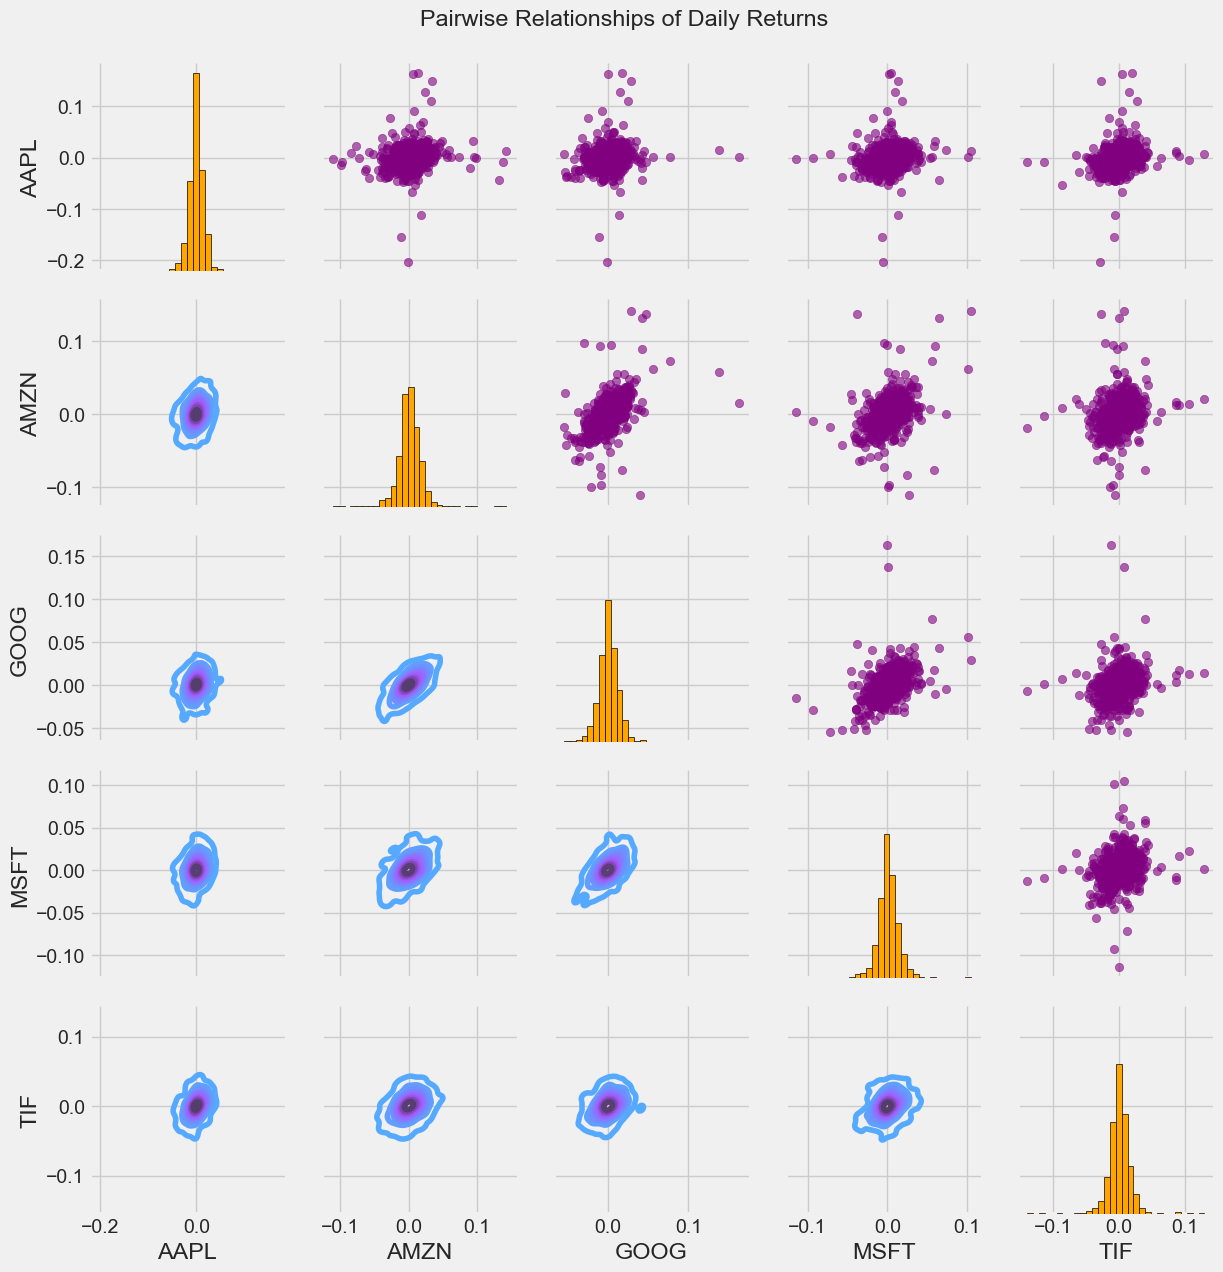

In [23]:
# Set up PairGrid for the cleaned DataFrame (drop NaN values)
cleaned_tech_rets = tech_rets.dropna()
return_fig = sns.PairGrid(cleaned_tech_rets)

# Define the upper triangle as scatter plots
return_fig.map_upper(plt.scatter, color='purple', alpha=0.6)

# Define the lower triangle as KDE plots with a cool colormap
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Define the diagonal as histograms of daily returns
return_fig.map_diag(plt.hist, bins=30, edgecolor='k', color='orange')

# Add a title for the entire plot
return_fig.fig.suptitle("Pairwise Relationships of Daily Returns", y=1.02)

# Show the plot
plt.show()

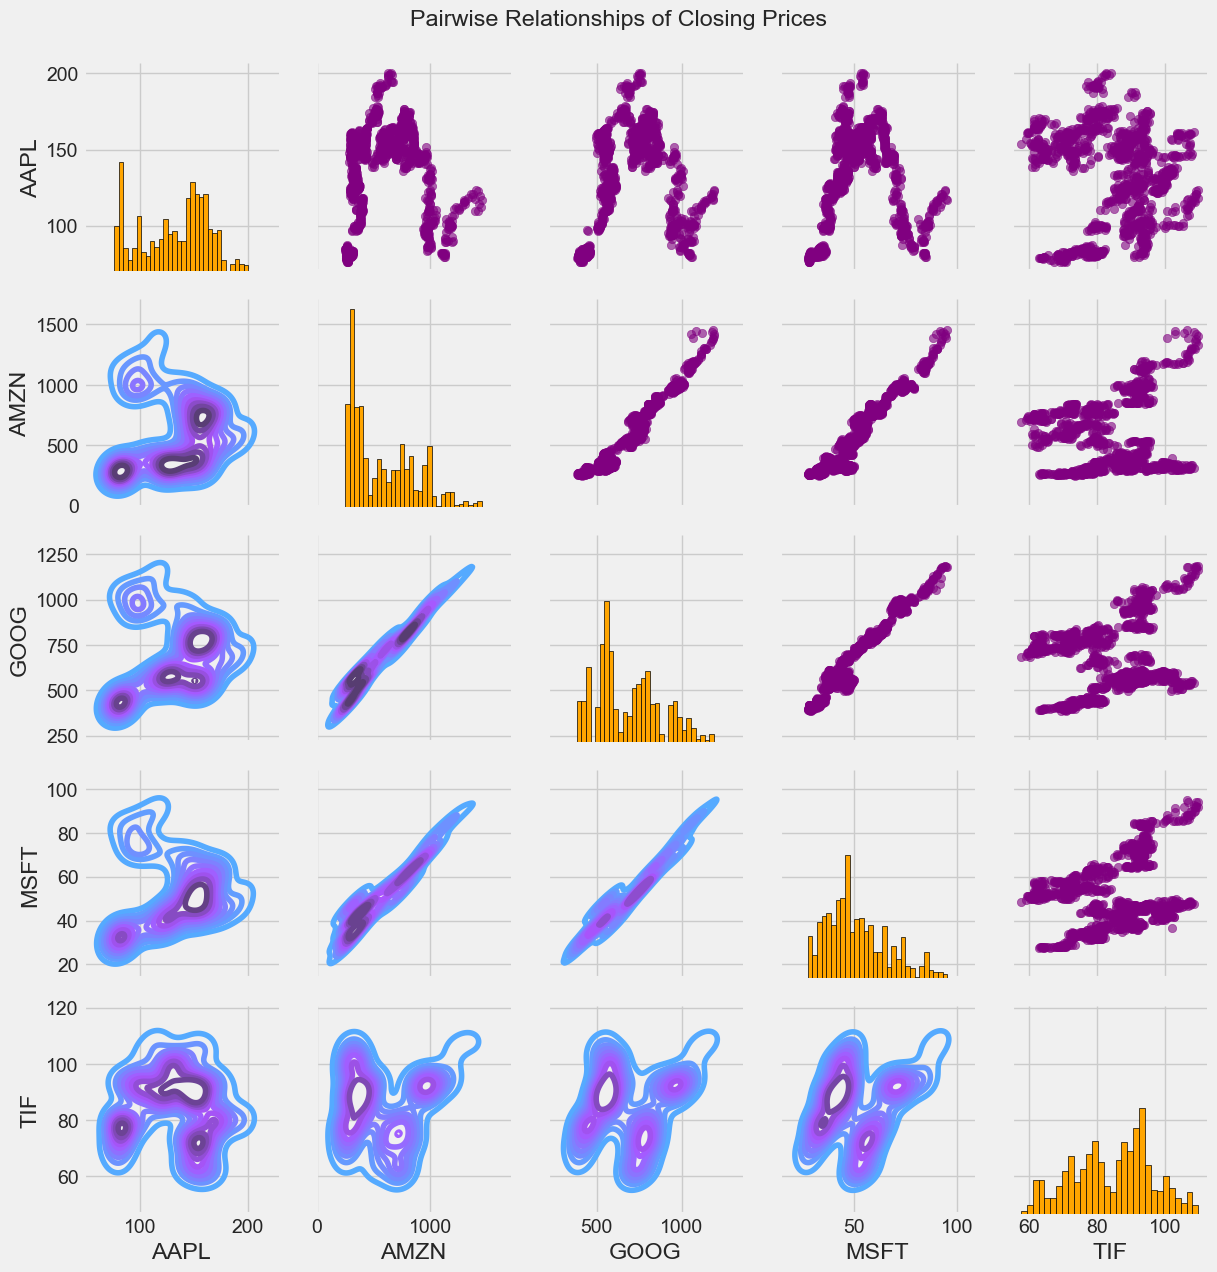

In [25]:
# Ensure 'closing_df' is cleaned to handle missing values
cleaned_closing_df = closing_df.dropna()

# Set up PairGrid on the cleaned DataFrame
returns_fig = sns.PairGrid(cleaned_closing_df)

# Define the upper triangle as scatter plots
returns_fig.map_upper(plt.scatter, color='purple', alpha=0.6)

# Define the lower triangle as KDE plots with a cool colormap
returns_fig.map_lower(sns.kdeplot, cmap='cool_d', warn_singular=False)

# Define the diagonal as histograms
returns_fig.map_diag(plt.hist, bins=30, edgecolor='k', color='orange')

# Add a title to the PairGrid
returns_fig.fig.suptitle("Pairwise Relationships of Closing Prices", y=1.02)

# Show the plot
plt.show()

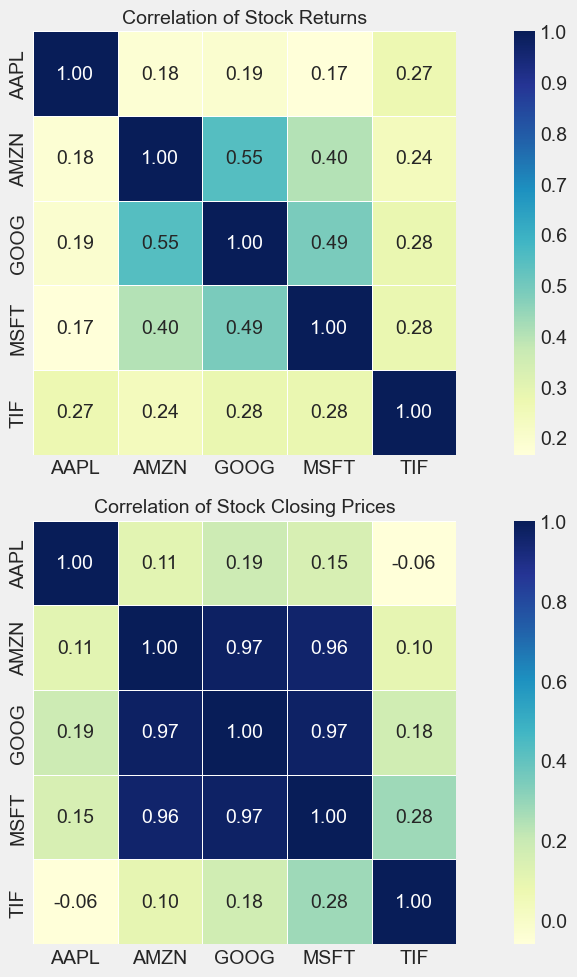

In [27]:
plt.figure(figsize=(12, 10))

# Plot 1: Correlation heatmap of stock returns
plt.subplot(2, 1, 1)
sns.heatmap(
    tech_rets.corr(), annot=True, cmap='YlGnBu', fmt=".2f", 
    cbar=True, linewidths=0.5, square=True
)
plt.title('Correlation of Stock Returns', fontsize=14)

# Plot 2: Correlation heatmap of stock closing prices
plt.subplot(2, 1, 2)
sns.heatmap(
    closing_df.corr(), annot=True, cmap='YlGnBu', fmt=".2f", 
    cbar=True, linewidths=0.5, square=True
)
plt.title('Correlation of Stock Closing Prices', fontsize=14)

plt.tight_layout()
plt.show()

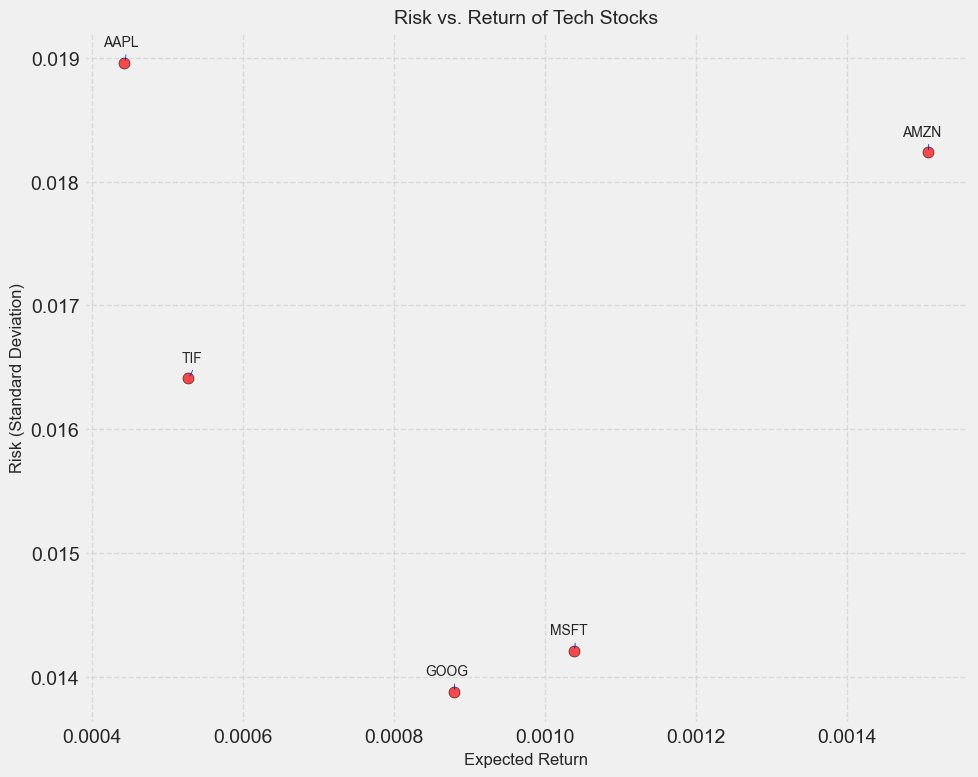

In [29]:
# Drop NaN values from returns DataFrame
rets = tech_rets.dropna()

# Area of scatter points
area = np.pi * 20

plt.figure(figsize=(10, 8))

# Scatter plot of risk (std deviation) vs. return (mean)
plt.scatter(
    rets.mean(), rets.std(), s=area, alpha=0.7, 
    color='red', edgecolors='black'
)
plt.xlabel('Expected Return', fontsize=12)
plt.ylabel('Risk (Standard Deviation)', fontsize=12)
plt.title('Risk vs. Return of Tech Stocks', fontsize=14)

# Annotate each stock
for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label,
        xy=(x, y),
        xytext=(10, 10),  # Slight offset for annotations
        textcoords='offset points',
        fontsize=10,
        ha='right', 
        va='bottom', 
        arrowprops=dict(
            arrowstyle='-', 
            color='blue', 
            connectionstyle='arc3,rad=-0.3'
        )
    )

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [31]:
import yfinance as yf
from datetime import datetime

# Define the stock ticker and date range
ticker = 'AAPL'
start_date = '2012-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Download the stock data
print(f"Downloading data for {ticker} from {start_date} to {end_date}...")
df = yf.download(ticker, start=start_date, end=end_date)

# Check if the dataset is empty
if df.empty:
    raise ValueError(f"The downloaded dataset for {ticker} is empty! Please check the ticker symbol and date range.")

# Display the first few rows of the data
print(f"\nDownloaded dataset for {ticker}:")
print(df.head())

# Display basic information about the dataset
print(f"\nDataset information for {ticker}:")
print(df.info())

[*********************100%***********************]  1 of 1 completed


Downloaded dataset for AAPL:
Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2012-01-03  12.388994  14.686786  14.732143  14.607143  14.621429  302220800
2012-01-04  12.455577  14.765714  14.810000  14.617143  14.642857  260022000
2012-01-05  12.593859  14.929643  14.948214  14.738214  14.819643  271269600
2012-01-06  12.725513  15.085714  15.098214  14.972143  14.991786  318292800
2012-01-09  12.705325  15.061786  15.276786  15.048214  15.196429  394024400

Dataset information for AAPL:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3248 entries, 2012-01-03 to 2024-11-27
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  3248 non-null   float64
 1   (Close, AAPL)      3248 non-null   float64
 2   (H

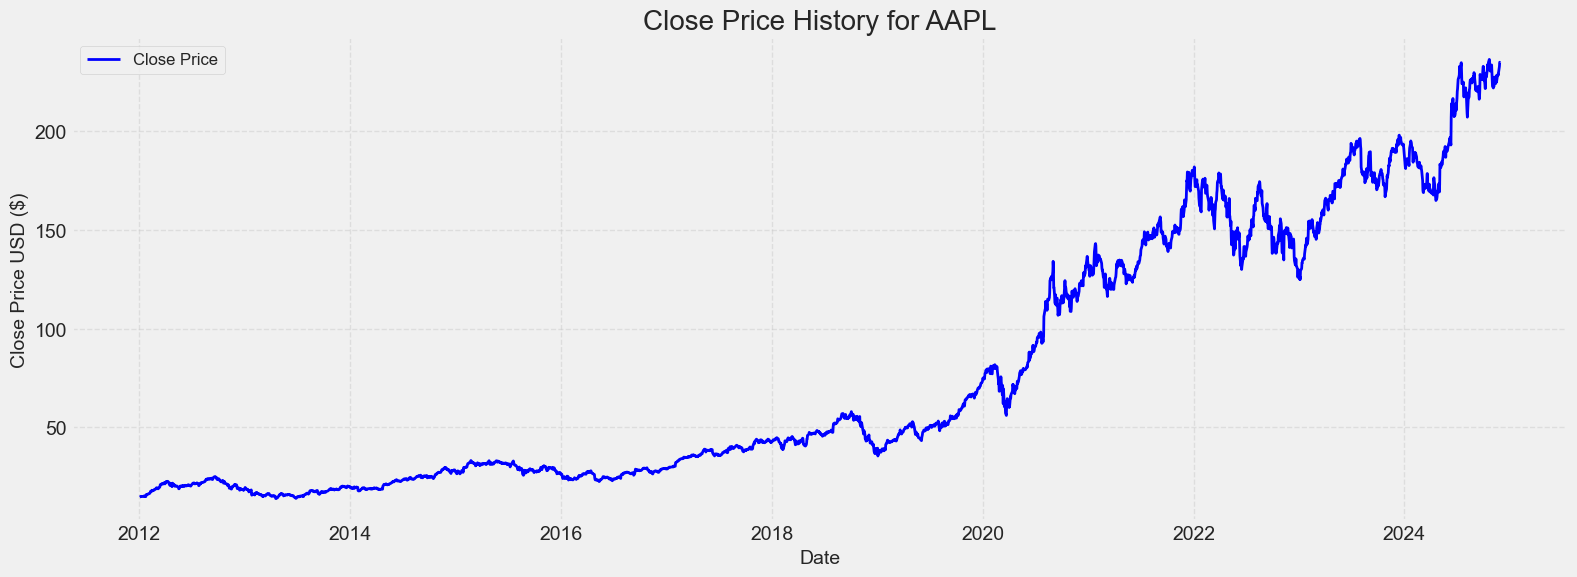

In [33]:
plt.figure(figsize=(16, 6))

# Plot the closing price
plt.plot(df['Close'], label='Close Price', color='blue', linewidth=2)

# Add title and axis labels
plt.title('Close Price History for AAPL', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

# Add gridlines for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
# Create a new DataFrame with only the 'Close' column
data = df[['Close']]

# Convert the DataFrame to a numpy array
dataset = data.values

# Check if the dataset is empty
if dataset.size == 0:
    raise ValueError("The dataset is empty! Ensure the 'Close' column contains valid data.")

# Print the dataset shape before scaling
print("Dataset shape before scaling:", dataset.shape)

# Calculate the number of rows to use for training (95% of the data)
training_data_len = int(np.ceil(len(dataset) * 0.95))

# Print the training data length
print("Training data length:", training_data_len)

Dataset shape before scaling: (3248, 1)
Training data length: 3086


In [36]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler with the range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Check if the dataset is valid before scaling
if dataset.size == 0:
    raise ValueError("The dataset is empty! Cannot apply MinMax scaling.")

# Scale the dataset
scaled_data = scaler.fit_transform(dataset)

# Print the shape of the scaled data for confirmation
print("Scaled data shape:", scaled_data.shape)

# Display the first few rows of the scaled data for verification
print("First 5 rows of scaled data:\n", scaled_data[:5])

Scaled data shape: (3248, 1)
First 5 rows of scaled data:
 [[0.00332215]
 [0.00367683]
 [0.00441348]
 [0.00511482]
 [0.00500729]]


In [37]:
# Create the training data set
# Use the first `training_data_len` rows for training
train_data = scaled_data[0:int(training_data_len), :]

# Initialize x_train and y_train
x_train = []
y_train = []

# Create sequences of 60 timesteps for training
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])  # Previous 60 timesteps as input
    y_train.append(train_data[i, 0])      # Current timestep as output/label
    if i <= 61:  # Debug the first two iterations
        print(f"x_train sample at index {i}:\n{x_train[-1]}")
        print(f"y_train sample at index {i}:\n{y_train[-1]}\n")

# Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape x_train to 3D for LSTM compatibility: (samples, timesteps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Print the shapes for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

# Additional check to ensure x_train and y_train align correctly
assert x_train.shape[0] == y_train.shape[0], "Mismatch between x_train and y_train sizes!"

x_train sample at index 60:
[0.00332215 0.00367683 0.00441348 0.00511482 0.00500729 0.00524963
 0.00513889 0.00495273 0.00469915 0.00548395 0.00619171 0.00597344
 0.00477779 0.00591888 0.00479545 0.00900831 0.00868252 0.00910782
 0.01002743 0.01058432 0.01053778 0.01036606 0.0110979  0.0117864
 0.01256638 0.01382623 0.01647271 0.01651284 0.01798614 0.0190871
 0.01719492 0.01792354 0.0179091  0.01995214 0.01966165 0.02019929
 0.02116544 0.02170309 0.02325182 0.02438006 0.02470586 0.02481981
 0.02289072 0.02242529 0.02249431 0.02430785 0.02481821 0.02591436
 0.02849824 0.03194558 0.0313004  0.03130201 0.03379442 0.03457441
 0.03401911 0.03351196 0.03298395 0.0347381  0.03594178 0.03644572]
y_train sample at index 60:
0.03520031440172121

x_train sample at index 61:
[0.00367683 0.00441348 0.00511482 0.00500729 0.00524963 0.00513889
 0.00495273 0.00469915 0.00548395 0.00619171 0.00597344 0.00477779
 0.00591888 0.00479545 0.00900831 0.00868252 0.00910782 0.01002743
 0.01058432 0.01053778 0.


LSTM Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)


Training the model...
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0406
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.2906e-04
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1019e-04
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.1335e-04
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 2.9249e-04
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 3.0695e-04
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.7875e-04
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.3915e-04
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.6817e-04
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 2.1776e-04


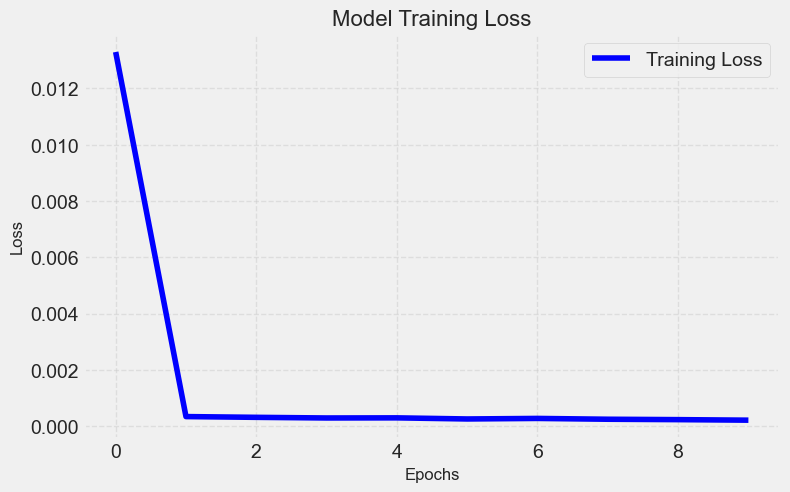

In [38]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build the LSTM model
model = Sequential()

# Input layer
model.add(Input(shape=(x_train.shape[1], 1)))  # Input shape: (timesteps, features)

# LSTM layers
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Fully connected (Dense) layers
model.add(Dense(25, activation='relu'))
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Summary of the model for clarity
print("\nLSTM Model Summary:")
model.summary()

# Train the model
print("\nTraining the model...")
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1)

# Plot training loss for monitoring
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Model Training Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [39]:
# Create the testing data set
# Use data from index training_data_len - 60 to the end for testing
test_data = scaled_data[training_data_len - 60:, :]

# Create x_test and y_test
x_test = []  # Input sequences for the model
y_test = dataset[training_data_len:, :]  # Actual values (not scaled)

# Generate x_test sequences (lookback window of 60 timesteps)
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])  # Use the last 60 timesteps as input

# Convert x_test to a numpy array
x_test = np.array(x_test)

# Reshape x_test to 3D shape for LSTM model: (samples, timesteps, features)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Make predictions using the trained model
print("\nMaking predictions...")
predictions = model.predict(x_test)

# Transform predictions back to original scale
predictions = scaler.inverse_transform(predictions)

# Calculate the root mean squared error (RMSE)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
print("\nRoot Mean Squared Error (RMSE):", rmse)

# Display the first few predictions and their corresponding actual values for validation
print("\nFirst 5 Predictions vs Actual Values:")
for i in range(5):
    print(f"Prediction: {predictions[i][0]:.2f}, Actual: {y_test[i][0]:.2f}")


Making predictions...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step

Root Mean Squared Error (RMSE): 5.484897484530931

First 5 Predictions vs Actual Values:
Prediction: 171.12, Actual: 167.78
Prediction: 170.78, Actual: 175.04
Prediction: 171.15, Actual: 176.55
Prediction: 172.02, Actual: 172.69
Prediction: 172.74, Actual: 169.38


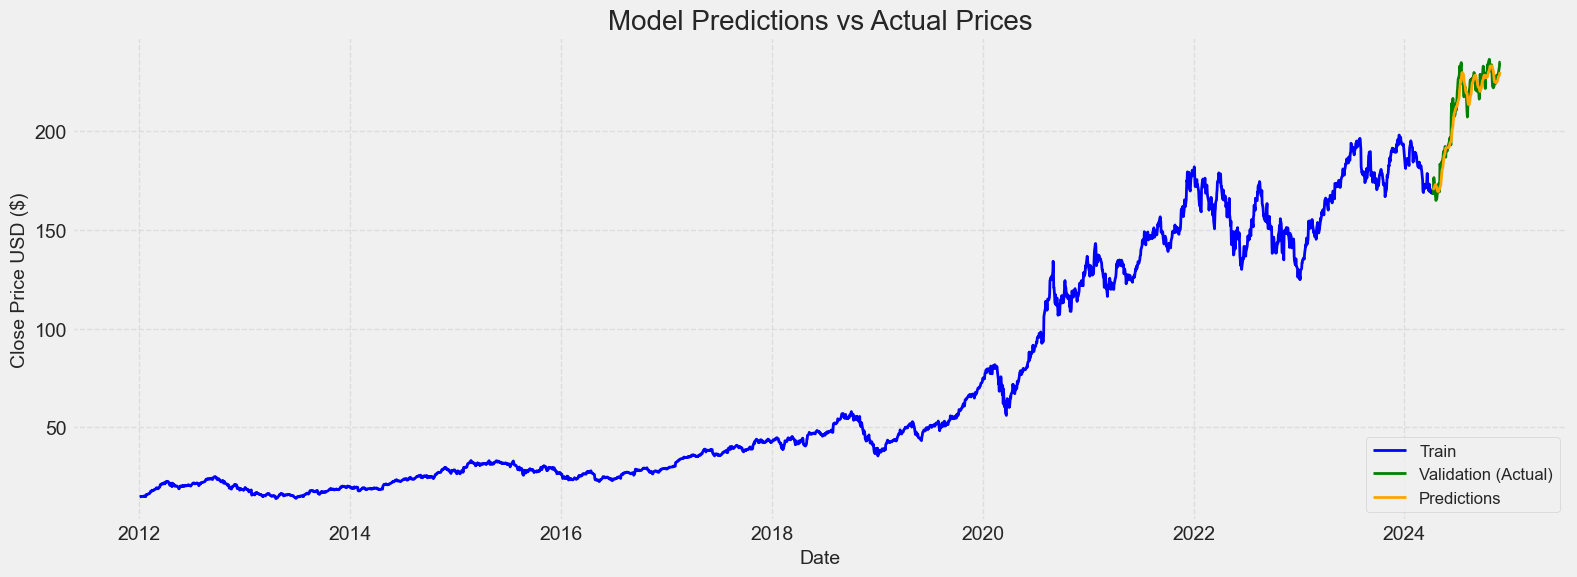

In [40]:
# Separate the training data
train = data[:training_data_len]

# Separate the validation data and add predictions
valid = data[training_data_len:].copy()
valid['Predictions'] = predictions

# Plot the data
plt.figure(figsize=(16, 6))
plt.title('Model Predictions vs Actual Prices', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(train['Close'], label='Train', color='blue', linewidth=2)
plt.plot(valid['Close'], label='Validation (Actual)', color='green', linewidth=2)
plt.plot(valid['Predictions'], label='Predictions', color='orange', linewidth=2)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [41]:
# Create a DataFrame to compare actual and predicted prices
valid = pd.DataFrame({
    "Actual": y_test.flatten(),
    "Predicted": predictions.flatten()
})

# Print the first few rows of the DataFrame for verification
print("\nComparison of Actual and Predicted Prices:")
print(valid.head())

# Print the total number of rows for context
print(f"\nNumber of rows in the comparison DataFrame: {valid.shape[0]}")

# Optionally return the DataFrame if needed
valid.head()


Comparison of Actual and Predicted Prices:
       Actual   Predicted
0  167.779999  171.123703
1  175.039993  170.779602
2  176.550003  171.153778
3  172.690002  172.021652
4  169.380005  172.743378

Number of rows in the comparison DataFrame: 162


,Actual,Predicted
0,167.779999,171.123703
1,175.039993,170.779602
2,176.550003,171.153778
3,172.690002,172.021652
4,169.380005,172.743378
